In [16]:
import os
import random
import cv2
import numpy as np
import seaborn as sns
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
from concurrent.futures import ProcessPoolExecutor

## Configuration

In [2]:
CORE = 4  # cpu core

# datasets directory
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

# image shape
ROWS = 128
COLS = 128
CHANNELS = 3

## Preparing dataset

Train shape: (25000, 128, 128, 3)
Test shape: (12500, 128, 128, 3)


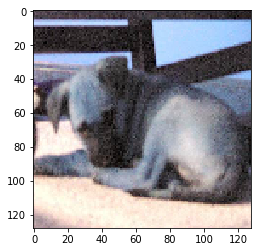

In [5]:
def key_sort_image(k):
    filename = k.split('.')[0]
    return int(filename)

train_images = os.listdir(TRAIN_DIR)
test_images =  [i for i in sorted(os.listdir(TEST_DIR), key=key_sort_image)]

# make fullpath
train_images = [os.path.join(TRAIN_DIR, i) for i in train_images]
test_images =  [os.path.join(TEST_DIR, i) for i in test_images]

# shuffle dataset
random.shuffle(train_images)

# reduce dataset for experimenting
# train_images = train_images[:1000]
# test_images =  test_images[:25]

def resize_img(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    with ProcessPoolExecutor(max_workers=CORE) as executor:
        data[:] = list(executor.map(resize_img, images))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

# check sample output
plt.imshow(train[0])
plt.show()

## Change label format

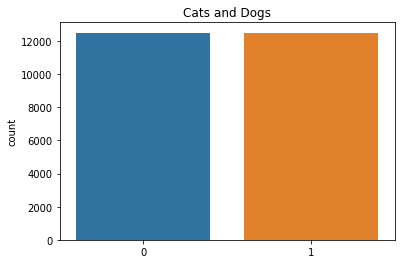

(25000, 2)


In [6]:
labels = [1 if 'dog' in i else 0 for i in train_images]
sns.countplot(labels)
plt.title('Cats and Dogs')
plt.show()

labels = keras.utils.to_categorical(labels, num_classes=2)
print(labels.shape)

## Check image and label
Get image and label randomly

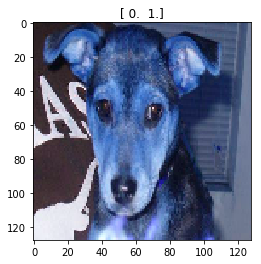

In [13]:
idx = random.randint(0, len(train))
plt.imshow(train[idx])
plt.title(labels[idx])
plt.show()

## Defined model
Using pretrained model, custom output layer and print summary

In [27]:
base_model = keras.applications.VGG16(
    weights = "imagenet", 
    include_top=False, 
    input_shape = (ROWS, COLS, CHANNELS))


for layer in base_model.layers[:5]:
    layer.trainable = False
    
# Add custom layer
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    loss="categorical_crossentropy", 
    optimizer = SGD(lr=0.0001, momentum=0.9, decay=1e-6),
    metrics=["accuracy"]
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

## Train model

In [28]:
epochs = 10
batch_size = 32
saved_weight = 'saved_weight'

# create directory if not exists
if not os.path.exists(saved_weight):
    os.makedirs(saved_weight)

checkpointer = ModelCheckpoint(
    filepath='saved_weight/weights.h5', 
    verbose=1, 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    mode='auto', 
    verbose=1)

callbacks = [early_stopping, checkpointer]
        
model.fit(train, labels, batch_size=batch_size, 
          epochs=epochs, validation_split=0.25, 
          verbose=1, shuffle=True, 
          callbacks=callbacks)

Train on 18750 samples, validate on 6250 samples
Epoch 1/10
18750/18750 [==============================] - 175s 9ms/step - loss: 0.4234 - acc: 0.8476 - val_loss: 0.1348 - val_acc: 0.9478
Epoch 2/10
18750/18750 [==============================] - 174s 9ms/step - loss: 0.1235 - acc: 0.9533 - val_loss: 0.0978 - val_acc: 0.9610
Epoch 3/10
18750/18750 [==============================] - 172s 9ms/step - loss: 0.0784 - acc: 0.9693 - val_loss: 0.1431 - val_acc: 0.9493
Epoch 4/10
18750/18750 [==============================] - 173s 9ms/step - loss: 0.0554 - acc: 0.9786 - val_loss: 0.0759 - val_acc: 0.9691
Epoch 5/10
18750/18750 [==============================] - 171s 9ms/step - loss: 0.0367 - acc: 0.9861 - val_loss: 0.0814 - val_acc: 0.9704
Epoch 6/10
18750/18750 [==============================] - 171s 9ms/step - loss: 0.0245 - acc: 0.9902 - val_loss: 0.0904 - val_acc: 0.9682
Epoch 7/10
18750/18750 [==============================] - 171s 9ms/step - loss: 0.0176 - acc: 0.9935 - val_loss: 0.1025 - v

# Prediction on test data

In [29]:
def category_to_kaggle_label(label):
    """Convert array output label    
    Dog using label 1 cat using label 2"""
    return 1 if np.argmax(label) == 1 else 0

predictions = list(map(category_to_kaggle_label, model.predict(test)))

data/test/10891.jpg


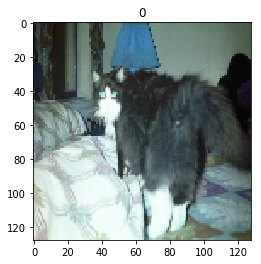

In [30]:
idx = random.randint(0, len(test))

print(test_images[idx])

plt.imshow(test[idx])
plt.title(predictions[idx])
plt.show()

## Save to csv
Using dataframe before save to csv

In [31]:
dt = pd.DataFrame({
    'id': pd.Series([i for i in range(1, len(test) + 1)], dtype=np.int),
    'label': pd.Series(predictions)
})
dt.to_csv('predictions.csv', index=False)
dt

,id,label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0
